# **IMPORTS, DATABASE CHECK, DATA MODELLING**

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

In [35]:
df = pd.read_csv("credit_risk.csv")

In [36]:
df.head()

,historia,divida,garantias,renda,risco
0,ruim,alta,nenhuma,0_15,alto
1,desconhecida,alta,nenhuma,15_35,alto
2,desconhecida,baixa,nenhuma,15_35,moderado
3,desconhecida,baixa,nenhuma,acima_35,alto
4,desconhecida,baixa,nenhuma,acima_35,baixo


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   historia   14 non-null     object
 1   divida     14 non-null     object
 2   garantias  14 non-null     object
 3   renda      14 non-null     object
 4   risco      14 non-null     object
dtypes: object(5)
memory usage: 692.0+ bytes


In [38]:
df.isnull().sum()

,0
historia,0
divida,0
garantias,0
renda,0
risco,0


In [39]:
risk_map = {
    "alto": "high",
    "moderado": "moderate",
    "baixo": "low"
}

df['risk'] = df['risco'].map(risk_map)

In [40]:
df.drop(columns=['risco'], inplace=True)
df.head()

,historia,divida,garantias,renda,risk
0,ruim,alta,nenhuma,0_15,high
1,desconhecida,alta,nenhuma,15_35,high
2,desconhecida,baixa,nenhuma,15_35,moderate
3,desconhecida,baixa,nenhuma,acima_35,high
4,desconhecida,baixa,nenhuma,acima_35,low


# **ENCODERS FOR CREDIT RISK CLASSES**

In [41]:
X = df.drop(columns=['risk'])
y = df['risk']

In [42]:
encoders = {}
for col in X.columns:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col])
    encoders[col] = enc

In [43]:
target_encoder = LabelEncoder()
y_enc = target_encoder.fit_transform(y)

In [44]:
for i, cls in enumerate(target_encoder.classes_):
    print(f"{i} = {cls}")

0 = high
1 = low
2 = moderate


# **DECISION TREE SETTING**


*   High interpretability
*   Easy to communicate
*   No scaling needed
*   Deterministic results
*   Good optino for small database



In [45]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X, y_enc)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [46]:
y_pred = clf.predict(X)
print(classification_report(y_enc, y_pred, target_names=target_encoder.classes_))

              precision    recall  f1-score   support

        high       0.86      1.00      0.92         6
         low       1.00      0.80      0.89         5
    moderate       1.00      1.00      1.00         3

    accuracy                           0.93        14
   macro avg       0.95      0.93      0.94        14
weighted avg       0.94      0.93      0.93        14



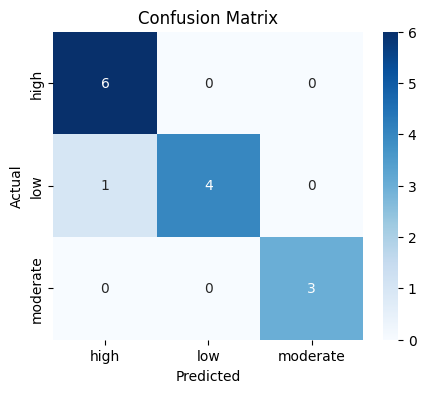

In [47]:
cm = confusion_matrix(y_enc, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_encoder.classes_,
    yticklabels=target_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Good resuls for all classes**

In [53]:
joblib.dump(clf, "risk_model.pkl")
joblib.dump(encoders, "encoders.pkl")
joblib.dump(target_encoder, "target_encoder.pkl")

['target_encoder.pkl']

# **TEST IN NEW DATA**

In [54]:
def predict_risk(new_data_csv):

    modelo = joblib.load("risk_model.pkl")
    encoders = joblib.load("encoders.pkl")
    target_encoder = joblib.load("target_encoder.pkl")

    novos = pd.read_csv(new_data_csv)

    for col in novos.columns:
        if col in encoders:
            novos[col] = encoders[col].transform(novos[col])

    previsoes_cod = modelo.predict(novos)
    previsoes = target_encoder.inverse_transform(previsoes_cod)

    return previsoes

In [50]:
new_data = pd.DataFrame({
    "historia": ["boa", "ruim"],
    "divida": ["baixa", "alta"],
    "garantias": ["nenhuma", "adequada"],
    "renda": ["acima_35", "0_15"]
})

new_applicants = new_data.copy()

In [51]:
for col in new_applicants.columns:
    le = encoders[col]
    new_applicants[col] = le.transform(new_applicants[col])

predictions = clf.predict(new_applicants)
probabilities = clf.predict_proba(new_applicants)[:, 1]

result = new_data.copy()
result['default_pred'] = target_encoder.inverse_transform(predictions)
result['default_prob'] = probabilities

display(result)

,historia,divida,garantias,renda,default_pred,default_prob
0,boa,baixa,nenhuma,acima_35,low,1.0
1,ruim,alta,adequada,0_15,high,0.0
